In [1]:
import os
import re
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import piexif
import pytesseract
pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"


from os import PathLike
from IPython.display import display
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy.stats import spearmanr
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from typing import cast, Tuple
from random import randint
from PIL import Image
from PIL.ExifTags import TAGS

from src.dataset import MammaliaDataSequence, MammaliaDataImage
from src.transform import ImagePipeline, BatchImagePipeline
from src.utils import load_path_yaml
from src.eval_helpers import *

set_custom_plot_style()
cm = 1 / 2.54

export = True
export_path = Path('./images')

eval = MammaliaEval(
    path_config='../data/path_config.yml',
    metrics=['balanced_accuracy_score'],
    force_metrics=False
    )

Loading pre-calculated metrics from file...


In [26]:
np.unique(df['class_label'].tolist())

array(['apodemus_sp', 'cricetidae', 'mustela_erminea', 'soricidae'],
      dtype='<U15')

In [37]:
df = eval.best_model.full_predicted_set.copy()

df_filtered = (
    df
    .query('correct == True' and 'class_label == "soricidae"')
    .sort_values('probs_max', ascending=False)
    )

chunker = DFChunker(df_filtered, chunk_size=12)

DataFrame has 12780 rows,
will be split into 1065 chunks of size 12.


Showing chunk 3 of 1065 chunks


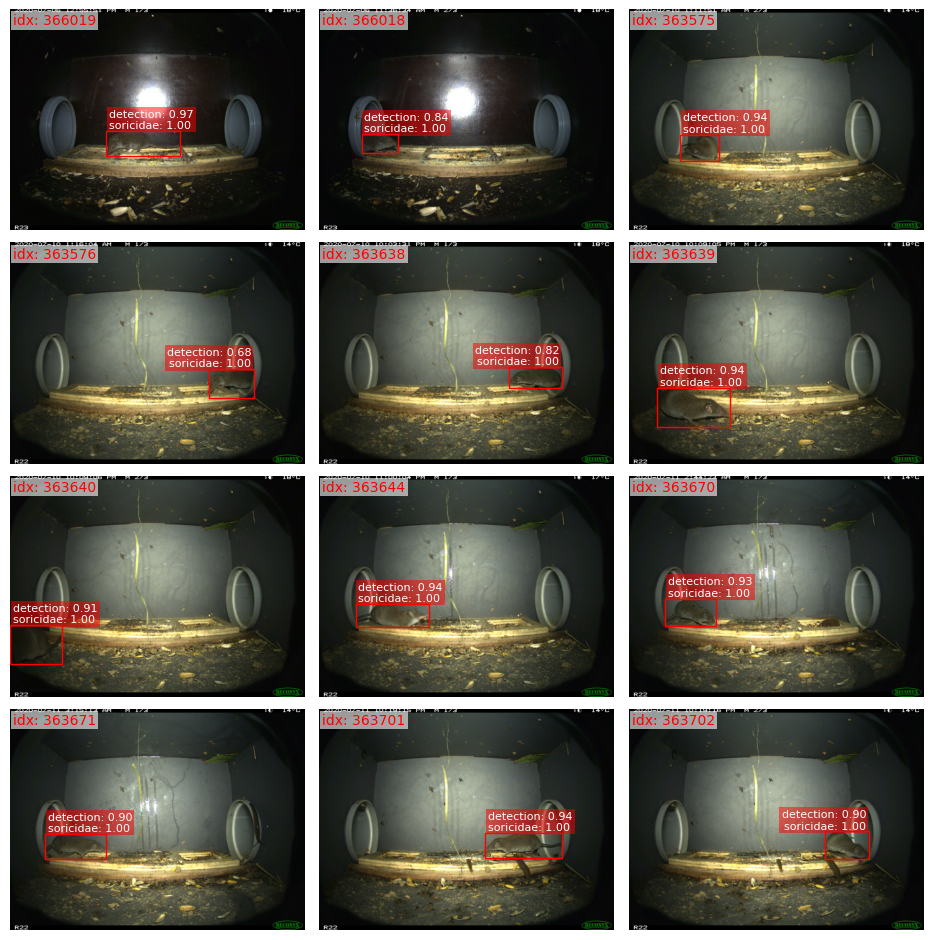

In [40]:
chunk = chunker.get_current_and_advance()
print(f"Showing chunk {chunker.current} of {len(chunker)} chunks")

plot_series_of_images(
    df=chunk, 
    dataset_path=eval.paths['dataset'],
    annotation_type='both',
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800,
    print_idx=True
    )

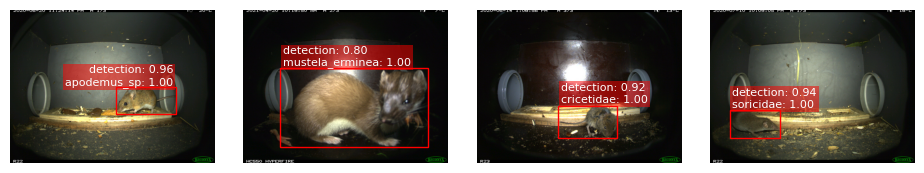

In [6]:
# Example for Topic
########################################################################################################################
selected_idx = [285053, 67503, 245781, 363639]
image_name = 'example_topic_images'
########################################################################################################################

df = eval.best_model.full_predicted_set.copy()

df_filtered = df[df['idx'].isin(selected_idx )]
df_filtered = df_filtered.set_index('idx').loc[selected_idx ].reset_index()

fig = plot_series_of_images(
    df=df_filtered, 
    dataset_path=eval.paths['dataset'],
    annotation_type='both',
    ncols=4, 
    fig_width_cm=24,
    offset_margin_conf_annotation=1000,
    print_idx='no'
    )

if export:
    fig.savefig(export_path / f'{image_name}.jpg', dpi=300)
    
display(fig)